# Setup Variables and home directory

MNIST, FashionMNIST, GTSRB, Cifar10

In [1]:
# set homw directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [50]:
DATASET = 'MNIST'
SEED = 42
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [53]:
# print available models
model_names = []
for i in (base / 'experiments' / DATASET / 'saved-models').iterdir():
    if i.name[:len(DATASET)] == DATASET:
        try: model_names.append(i.name.replace(DATASET + '_', ''))
        except: continue
        
model_names.sort(key=lambda x: int(x.split('-')[-1]))
model_names

['SGD-64-30', 'SGD-64-60', 'SGD-64-100']

In [54]:
POSTFIX = model_names[0]
FILENAME_POSTFIX = f'{DATASET}_{POSTFIX}'

In [55]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fastprogress import progress_bar

In [57]:
from utilities.utils import load_json, load_pickle, split_data
from utilities.pathManager import fetchPaths

# Paths

In [58]:
paths = fetchPaths(base, DATASET, POSTFIX, False)

path_data = paths['data']
path_lhl = paths['lhl']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_pca']

# Seed

In [59]:
np.random.seed(SEED)

# Import Data

In [60]:
FLAVOR = 'raw'

if FLAVOR == 'raw':
    path_lhl = path_lhl_raw
else: path_lhl = path_lhl_pca

# import Data
df_train = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_train.csv")
df_test = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{FLAVOR}_test.csv")

# LHL

In [61]:
# sample_indecies = split_data(df_train['y'], 0.2)
sample_indecies = df_train.index

In [62]:
# df_train.loc[df_train_sample, 'y'].value_counts()

In [63]:
df_train_sample = df_train.loc[sample_indecies].reset_index(drop=True)

y_sample = df_train_sample['y']
true_sample = df_train_sample['true']

df_train_sample = df_train_sample.drop(['y', 'true'], axis=1).to_numpy()

### Scalers

In [64]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [65]:
scale = StandardScaler()
minmax = MinMaxScaler()
robust = RobustScaler()


scale_sample = scale.fit_transform(df_train_sample)
minmax_sample = minmax.fit_transform(df_train_sample)
robust_sample = robust.fit_transform(df_train_sample)

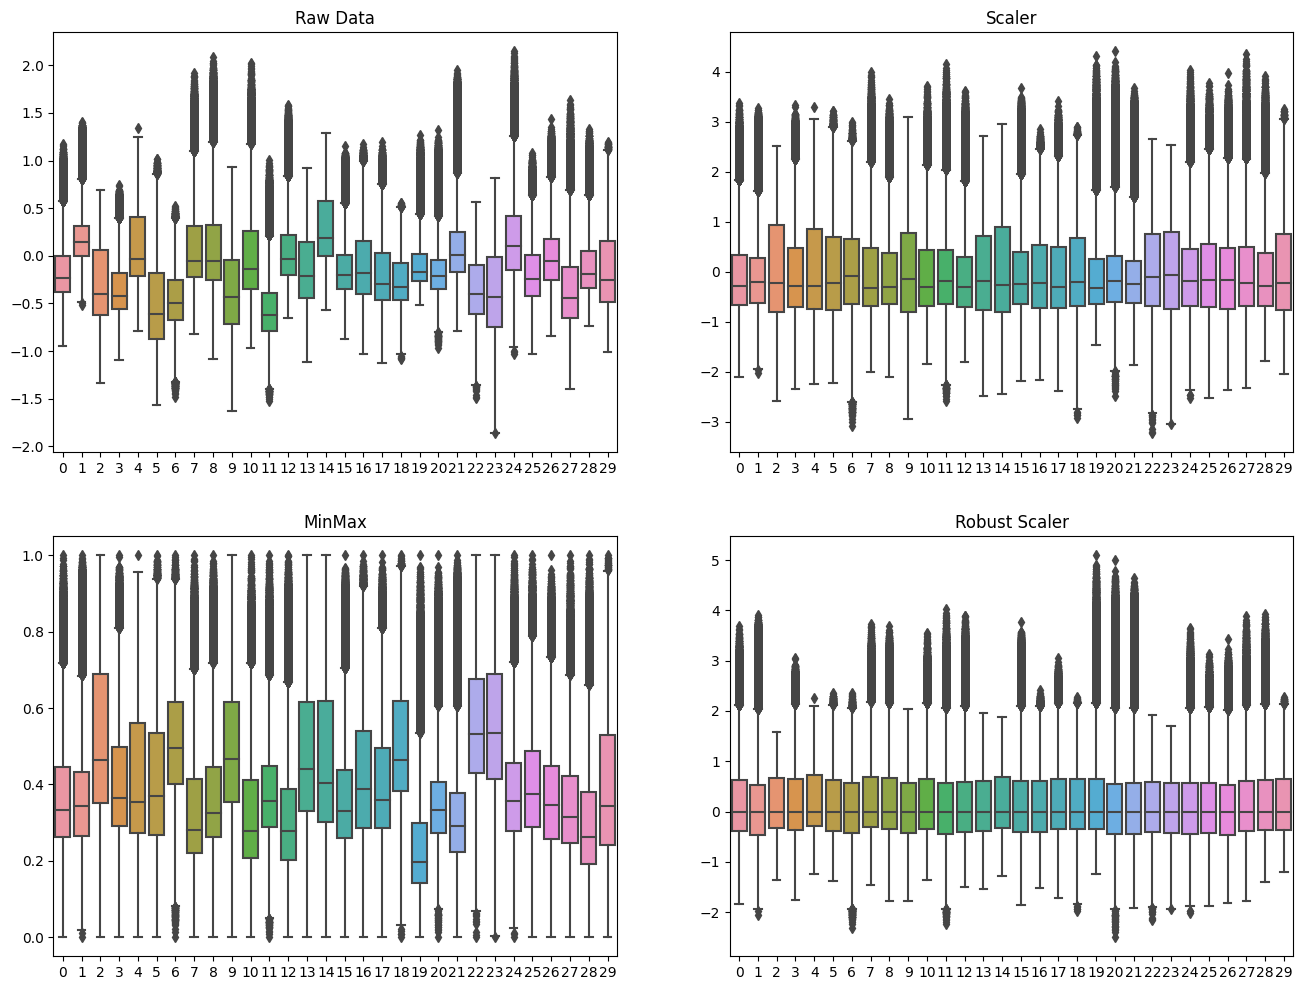

In [66]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

sns.boxplot(df_train_sample, ax=ax[0, 0])
sns.boxplot(scale_sample, ax=ax[0, 1])
sns.boxplot(minmax_sample, ax=ax[1, 0])
sns.boxplot(robust_sample, ax=ax[1, 1])

ax[0,0].set_title('Raw Data')
ax[0,1].set_title('Scaler')
ax[1,0].set_title('MinMax')
ax[1,1].set_title('Robust Scaler')

plt.show()

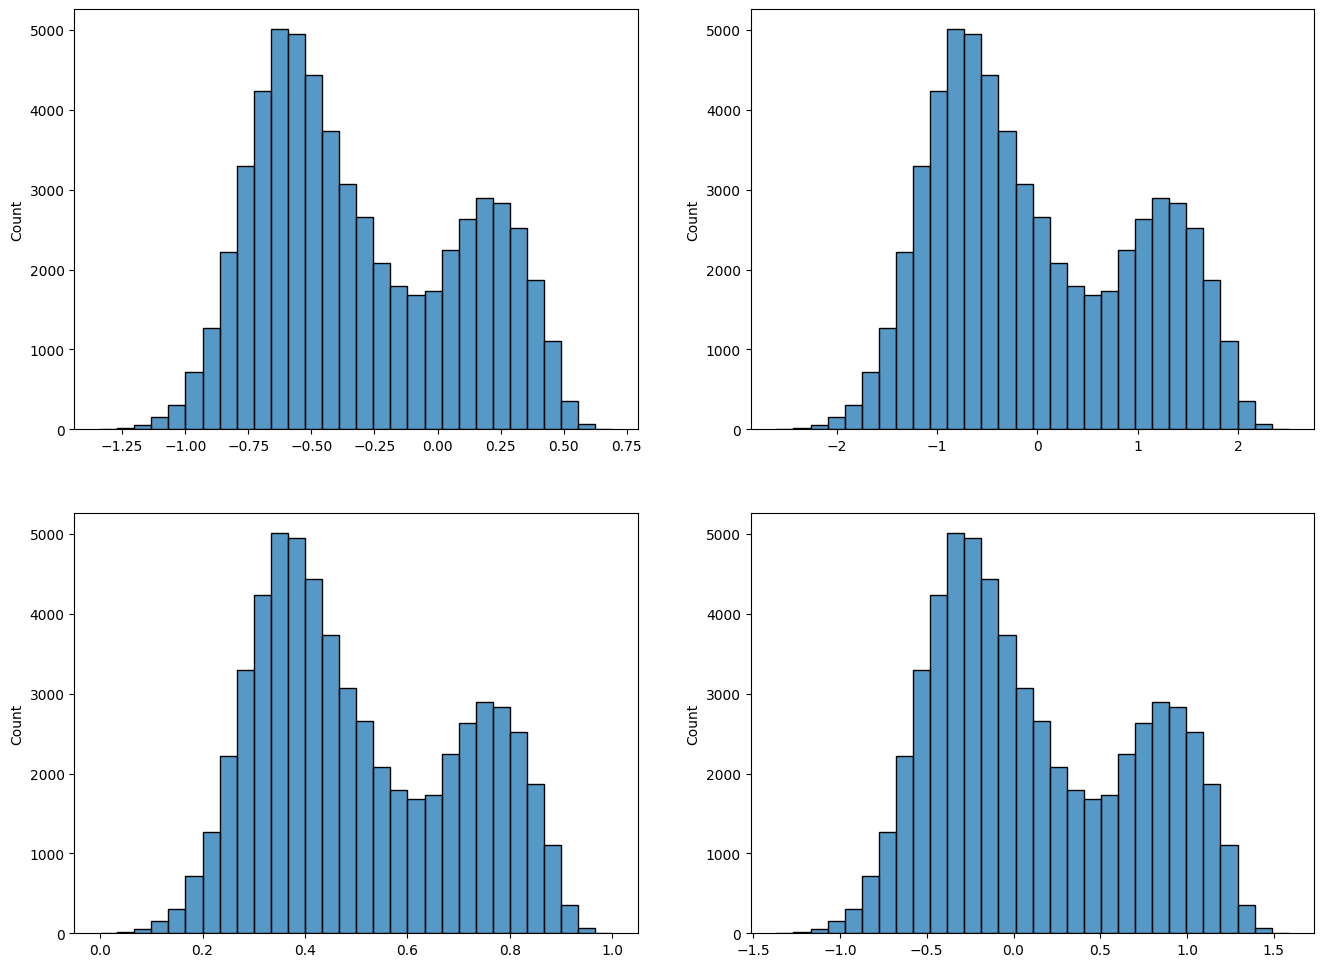

In [67]:
neuron = 2
bins=30

fig, ax = plt.subplots(2, 2, figsize=(16,12))


sns.histplot(df_train_sample[:, neuron], bins=bins, ax=ax[0, 0])
sns.histplot(scale_sample[:, neuron], bins=bins, ax=ax[0, 1])
sns.histplot(minmax_sample[:, neuron], bins=bins, ax=ax[1, 0])
sns.histplot(robust_sample[:, neuron], bins=bins, ax=ax[1, 1])


plt.show()

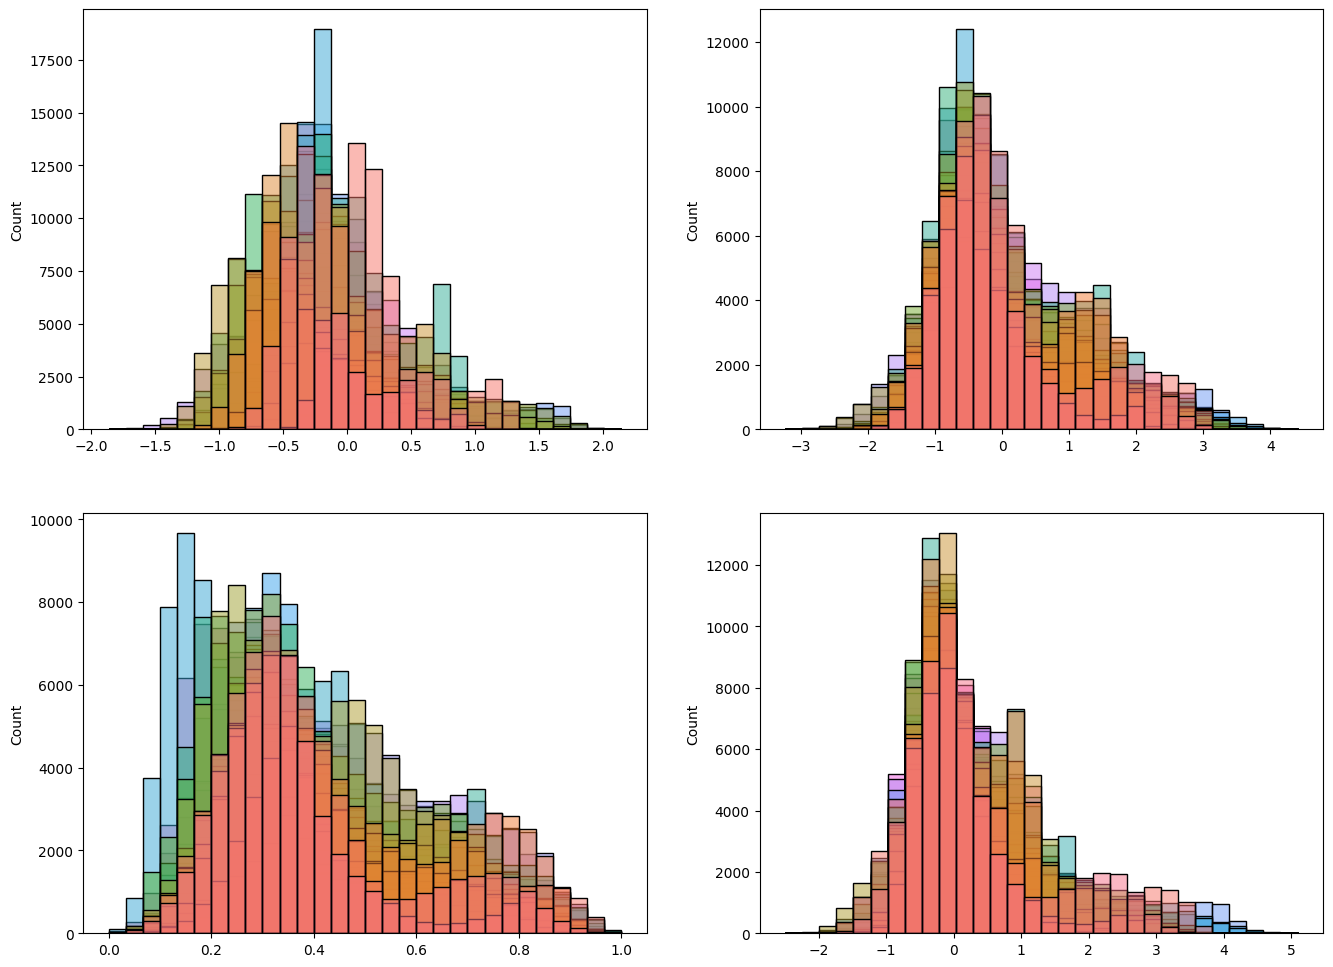

In [68]:
bins=30

fig, ax = plt.subplots(2, 2, figsize=(16,12))


sns.histplot(df_train_sample, bins=bins, ax=ax[0, 0])
sns.histplot(scale_sample, bins=bins, ax=ax[0, 1])
sns.histplot(minmax_sample, bins=bins, ax=ax[1, 0])
sns.histplot(robust_sample, bins=bins, ax=ax[1, 1])

for a in ax.flatten(): a.get_legend().remove()

plt.show()

## Normal Dist test

[D’Agostino and Pearson’s](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#r7bf2e556f491-1)

In [69]:
from scipy.stats import normaltest

In [70]:
p_value_thld = 1e-2

In [71]:
normality_test = pd.DataFrame({
    'neurons': df_train.drop(['y', 'true'], axis=1).columns,
    'raw': normaltest(df_train_sample).pvalue <  p_value_thld,
    'scalar': normaltest(scale_sample).pvalue <  p_value_thld,
    'minmax': normaltest(minmax_sample).pvalue <  p_value_thld,
    'robust': normaltest(robust_sample).pvalue <  p_value_thld
})

In [72]:
normality_test.iloc[:, 1:].all()

raw       True
scalar    True
minmax    True
robust    True
dtype: bool

### PCA

In [73]:
from sklearn.decomposition import PCA

In [74]:
pca_train = PCA()
pca_scale = PCA()
pca_minmax = PCA()
pca_robust = PCA()


pca_df_train = pca_train.fit_transform(df_train_sample)
pca_df_scale = pca_scale.fit_transform(scale_sample)
pca_df_minmax = pca_minmax.fit_transform(minmax_sample)
pca_df_robust = pca_robust.fit_transform(robust_sample)

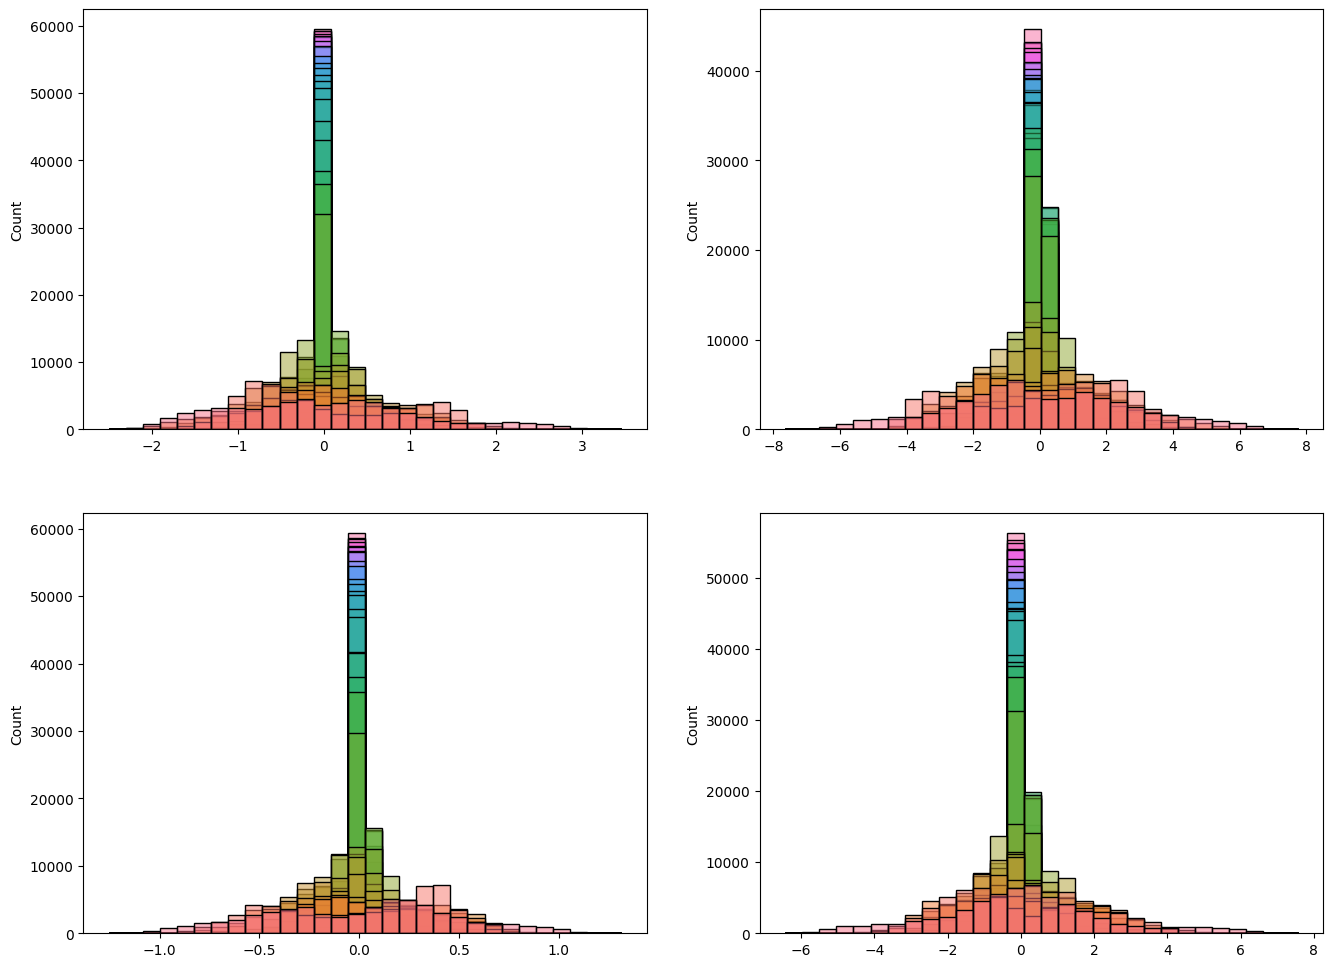

In [75]:
bins=30

fig, ax = plt.subplots(2, 2, figsize=(16,12))


sns.histplot(pca_df_train, bins=bins, ax=ax[0, 0])
sns.histplot(pca_df_scale, bins=bins, ax=ax[0, 1])
sns.histplot(pca_df_minmax, bins=bins, ax=ax[1, 0])
sns.histplot(pca_df_robust, bins=bins, ax=ax[1, 1])

for a in ax.flatten(): a.get_legend().remove()

plt.show()

### PCA Loadings

In [76]:
var_thld = 0.9
loadings_thld=0.2
numNeurons = df_train_sample.shape[1]

In [77]:
num_component = sum(np.cumsum(pca_scale.explained_variance_ratio_).round(2) <= var_thld)

pca_scale_components = pd.DataFrame(
    pca_scale.components_[:,:num_component],
    columns=[f'PC_{i}' for i in range(1, num_component+1)],
    index=[f'x{i}' for i in range(numNeurons)]
)

pca_scale_loadings = (pca_scale_components * np.sqrt(pca_scale.explained_variance_[:num_component])).abs()

<Axes: >

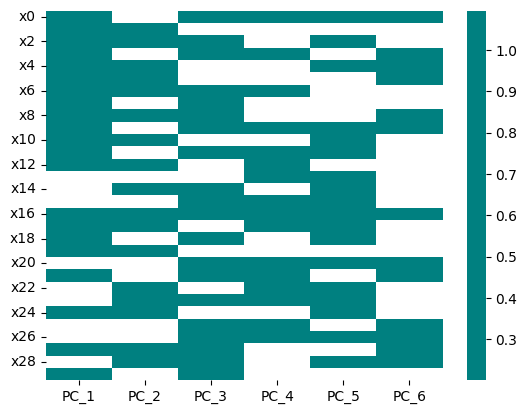

In [78]:
sns.heatmap(pca_scale_loadings, mask=pca_scale_loadings < loadings_thld, cmap=['teal'])

In [79]:
pca_scale_loadings.describe().T

,count,mean,std,min,25%,50%,75%,max
PC_1,30.0,0.386563,0.309990,0.008169,0.123755,0.318300,0.523421,1.083658
PC_2,30.0,0.316372,0.280606,0.024009,0.072304,0.263523,0.465318,1.095277
PC_3,30.0,0.330412,0.214955,0.006891,0.162038,0.302431,0.458258,0.752862
PC_4,30.0,0.285289,0.204679,0.033619,0.135477,0.245456,0.444725,0.784805
PC_5,30.0,0.267645,0.178364,0.061844,0.127526,0.229044,0.358500,0.739095
PC_6,30.0,0.202810,0.155405,0.001917,0.066057,0.160958,0.344868,0.547392


In [80]:
pca_scale.explained_variance_ratio_

array([2.42317716e-01, 1.76202950e-01, 1.53834613e-01, 1.21884803e-01,
       1.02385451e-01, 6.44763997e-02, 4.78894821e-02, 4.22933965e-02,
       2.62325628e-02, 4.72853121e-03, 2.88383273e-03, 2.10430872e-03,
       2.10080036e-03, 1.83391759e-03, 1.13684546e-03, 1.01445951e-03,
       9.03242653e-04, 8.27012001e-04, 7.81569310e-04, 7.01761936e-04,
       5.59722723e-04, 5.04136920e-04, 4.04755879e-04, 3.76068961e-04,
       3.36787261e-04, 3.17777141e-04, 2.87156553e-04, 2.54313862e-04,
       2.40673370e-04, 1.84951007e-04])

In [81]:
pca_scale_loadings

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
x0,0.201521,0.090766,0.372752,0.601310,0.518384,0.250677
x1,0.713255,0.560951,0.154987,0.116903,0.121469,0.098522
x2,0.433219,0.272836,0.396746,0.090690,0.363011,0.133259
x3,0.563198,0.182224,0.732744,0.301158,0.063955,0.363081
x4,0.473738,0.561417,0.127933,0.197028,0.260889,0.387897
x5,0.299916,0.201720,0.073354,0.143901,0.079279,0.398780
x6,0.210586,1.095277,0.487257,0.467365,0.120046,0.133540
x7,0.905758,0.049057,0.455806,0.046667,0.076549,0.043121
x8,0.446381,0.585124,0.218800,0.069205,0.147953,0.220286
x9,0.454657,0.030546,0.286152,0.239195,0.739095,0.215718


In [82]:
(pca_scale_loadings >= loadings_thld).any(axis=1).index.shape

(30,)

In [83]:
var_expl_comp = (pca_scale.explained_variance_[:num_component] / pca_scale.explained_variance_[:num_component].sum())
var_expl_comp

array([0.28140422, 0.20462496, 0.17864855, 0.14154515, 0.1189005 ,
       0.07487662])

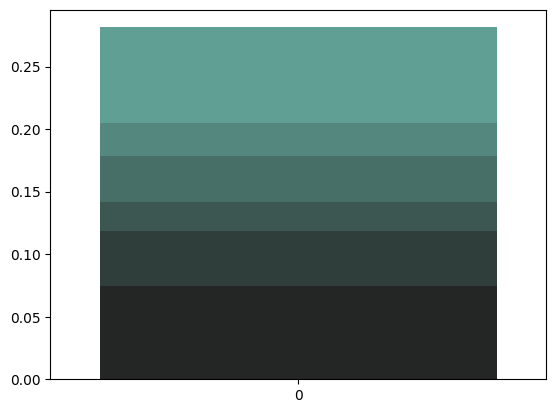

In [86]:
palette=sns.color_palette("dark:#5A9_r", len(var_expl_comp))

for i, e in zip(range(len(var_expl_comp)), var_expl_comp[:len(var_expl_comp)]):
    sns.barplot(x=[0] , y=[e], palette=[palette[i]])

In [87]:
neuron_loadings_scale = ((pca_scale_loadings >= loadings_thld) * var_expl_comp).sum(axis=1)
neuron_loadings_scale

x0     0.795375
x1     0.486029
x2     0.783578
x3     0.676475
x4     0.679806
x5     0.560906
x6     0.806223
x7     0.460053
x8     0.739554
x9     0.795375
x10    0.604930
x11    0.720498
x12    0.627574
x13    0.260446
x14    0.502174
x15    0.439094
x16    1.000000
x17    0.746475
x18    0.578953
x19    0.486029
x20    0.513971
x21    0.676475
x22    0.465071
x23    0.643719
x24    0.604930
x25    0.395070
x26    0.513971
x27    0.739554
x28    0.577051
x29    0.460053
dtype: float64

In [88]:
neuron_loadings_scale.describe()

count    30.000000
mean      0.611314
std       0.155125
min       0.260446
25%       0.490065
50%       0.604930
75%       0.734790
max       1.000000
dtype: float64

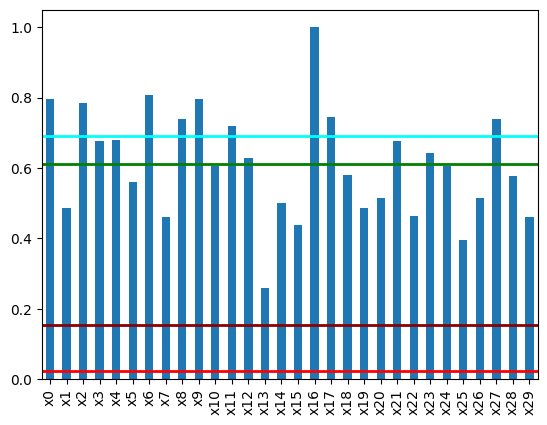

In [89]:
neuron_loadings_scale.plot.bar()

plt.axhline(neuron_loadings_scale.quantile(0.7), color='aqua', linewidth=2, label='Qt 7')
plt.axhline(neuron_loadings_scale.mean(), color='green', linewidth=2, label='Mean')
plt.axhline(neuron_loadings_scale.std(), color='darkred', linewidth=2, label='Std')
plt.axhline(neuron_loadings_scale.var(), color='red', linewidth=2, label='Var')

plt.show()

In [90]:
# top 3rd of numNeurons
neuron_loadings_scale.sort_values(ascending=False)[:numNeurons // 3].index.to_list()

['x16', 'x6', 'x0', 'x9', 'x2', 'x17', 'x27', 'x8', 'x11', 'x4']

In [91]:
# more than the mean
neuron_loadings_scale[neuron_loadings_scale >= neuron_loadings_scale.mean()].index.to_list()

['x0',
 'x2',
 'x3',
 'x4',
 'x6',
 'x8',
 'x9',
 'x11',
 'x12',
 'x16',
 'x17',
 'x21',
 'x23',
 'x27']

In [92]:
from utilities.scaleFunctions import applyStandardScalerSingle
from utilities.pcaFunctions import applyPCASingle, numComponents, neuronsLoadingsSingle

In [93]:
scaler, scaled_data = applyStandardScalerSingle(pd.DataFrame(df_train_sample), df_train_sample.shape[1])

In [94]:
pca, pca_data = applyPCASingle(pd.DataFrame(df_train_sample), scaler)

In [95]:
(pca.components_ == pca_scale.components_).all().all()

True

In [96]:
(pca.explained_variance_ == pca_scale.explained_variance_).all().all()

True

In [97]:
gte_mean, top_third = neuronsLoadingsSingle(pca)

In [98]:
set(gte_mean) - set(neuron_loadings_scale[neuron_loadings_scale >= neuron_loadings_scale.mean()].index.to_list())

set()

In [99]:
set(top_third) - set(neuron_loadings_scale.sort_values(ascending=False)[:pca_scale_loadings.shape[0] // 3].index.to_list())

set()